# Import Library 

In [1]:
# Run this if you start using this notebook for the first time
#import sys
from os import getcwd, mkdir
#!{sys.executable} -m pip install -r "../../requirements.txt"

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import PIL
import scipy.ndimage as sciim
from scipy.signal import savgol_filter
from os.path import abspath
from time import time
from ctypes import *
print(abspath(""))
IMG_DIRPATH = "../../img/"
SO_DIRPATH = "../libs/"

/home/adityap/Documents/Handwritting - Detection/HandWritting-Digit-Detection/src/JupyterNotebook


# Load  C Shared Library 

In [3]:
# Struct
class Image(Structure):
  _fields_ = [
    ("img", POINTER(c_ubyte)), 
    ("nx", c_int), 
    ("ny", c_int), 
  ]
class Position(Structure):
   _fields_ = [
     ("x", c_uint32), 
     ("y", c_uint32), 
   ]
class Data(Structure):
  _fields_ = [
    ("object", POINTER(POINTER(POINTER(Position)))), 
    ("length", c_int)
  ]
class dynArr(Structure):
    _fields_ = [
        ("arr", POINTER(c_void_p)), 
        ("end", c_int), 
        ("max", c_int), 
    ]

In [4]:
SO_FILE_BBOX = SO_DIRPATH + 'libbbox.so'
bbox_c = CDLL(SO_FILE_BBOX)
bbox_c.python_bbox_find.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
bbox_c.python_bbox_find.restype = POINTER(Data)
bbox_c.get_shapes.argtypes = [POINTER(Image), POINTER(Data), c_int, c_int, c_int]
bbox_c.get_shapes.restype = POINTER(Image)
bbox_c.sortObjs.argtypes = [POINTER(Data)]
bbox_c.sortObjs.restypes = POINTER(dynArr)

In [5]:
# Thresh
SO_FILE_THRESH = SO_DIRPATH + 'libthresh.so'
thresh_c = CDLL(SO_FILE_THRESH)
thresh_c.python_thresh_images.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int, c_ubyte, c_ubyte]
thresh_c.python_thresh_images.restype = POINTER(Image)

In [6]:
# Image To Serial and Serial To Images
SO_FILE_IMAGES = SO_DIRPATH + 'libimage.so'
image_c = CDLL(SO_FILE_IMAGES)
image_c.image_to_serial.argtypes = [POINTER(POINTER(c_ubyte)), c_int, c_int]
image_c.image_to_serial.restype = POINTER(c_ubyte)
image_c.serial_to_image.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
image_c.serial_to_image.restype = POINTER(POINTER(c_ubyte))

In [7]:
# Loop Counter
SO_FILE_COUNTER = SO_DIRPATH + 'libcounter.so'
counter_c = CDLL(SO_FILE_COUNTER)
counter_c.python_loop_count.argtypes = [np.ctypeslib.ndpointer(dtype=c_ubyte, flags="C_CONTIGUOUS"), c_int, c_int]
counter_c.python_loop_count.restypes = c_int

In [8]:
mat = np.array([[1, 2], [3, 4]], dtype='ubyte')

# C Interface Function

In [9]:
def serializeArray_c(pixels, nx, ny):
    pixels_ptr = POINTER(c_ubyte) * ny
    temp = []
    for i in range(ny):
        temp.append(cast(np.ctypeslib.as_ctypes(pixels[i]), POINTER(c_ubyte)))
    
    pixels_ptr = cast(pixels_ptr(*temp), POINTER(POINTER(c_ubyte)))
    
    data_ptr = image_c.image_to_serial(pixels_ptr, nx, ny)
    return np.ctypeslib.as_array(data_ptr, (nx * ny,))

def toMatrix(serial, nx, ny):
    shape = np.shape(serial)
    if not isinstance(serial, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
    
    try:
        data_ptr = image_c.serial_to_image(serial, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined image_c. Make sure to load image_c library first before running this function\n")
        print("Make sure to defined the restype and argtype of serial_to_image")
        exit(-1)
    
    mat = [None for i in range(ny)]
    for i in range(ny):
        mat[i] = np.ctypeslib.as_array(data_ptr[i] ,shape=(nx,))
    return np.array(mat)
    
    
def bbox_pipeline(img : np.ndarray, nx, ny):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"

    #pixels_serialize = serializeArray(img, nx, ny)
  
    try:
        data_ptr = bbox_c.python_bbox_find(img, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined bbox. Make sure to load bbox library first before running this function\n")
        print("Make sure to defined the restype and argtype of bbox_python_find")
        exit(-1)
  
    try:
        data : Data = data_ptr.contents
        arr_of_arr_of_pos_ptr = data.object
        arr_length = data.length
        frames = []
        frames_arr = (POINTER(POINTER(Position))) * arr_length
    
        for i in range(arr_length):
            arr_of_pos_ptr = arr_of_arr_of_pos_ptr[i]
            frames.append(arr_of_pos_ptr)

        frames_arr = frames_arr(*frames)
            
    except Exception as e:
        print("Exception raised while getting data from pointer with erro:")
        print(e)
    
    return cast(frames_arr, POINTER(POINTER(POINTER(Position)))), arr_length

def get_shapes(img, data, start, end, idx):
    if not isinstance(img, Image):
        raise TypeError("objs must have type of {}, get {}".format(type(Image).__name__, type(img).__name__))

    if not isinstance(data, Data):
        raise TypeError("objs must have type of {}, get {}".format(type(Data).__name__, type(data).__name__))

    try:
        img_ptr = bbox_c.get_shapes(img, data, start, end, idx)
        img_data = img_ptr.contents
        shapes = np.ctypeslib.as_array(img_data.img, (img_data.nx * img_data.ny, ))
    except Exception as e:
        print("Exception occured in get shapes with error:")
        print(e)
        exit(-1)

    return shapes, (img_data.nx, img_data.ny)

def sortObjs_c(objs):
    # if not isinstance(pos, POINTER(POINTER(POINTER(Position)))): 
    #     raise TypeError("objs must have type of LP_LP_LP_Data, get {}".format(type(pos).__name__))
    if not isinstance(objs, Data):
        raise TypeError("objs must have type of {}, get {}".format(type(Data).__name__, type(objs).__name__))

    try:
        # objs = Data(pos, n)    
        partitions_ptr = bbox_c.sortObjs(pointer(objs))
        partitions_ptr = (dynArr * 1).from_address(partitions_ptr)
        partition_obj = partitions_ptr[0]
        partition = np.zeros((partition_obj.end + 1, ))
        
        for i in range(partition_obj.end + 1):
            int_pointer  = (c_int * 1).from_address(partition_obj.arr[i])
            partition[i] = int_pointer[0]
            
    except Exception as e:
        print(e)
        exit(-1)

    return partition

def thresh_pipeline(img, nx, ny, thresh):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
  
    #pixels_serialize = serializeArray(img, nx, ny)
    print(img)
    try:
        data_ptr = thresh_c.python_thresh_images(img, nx, ny, 0, thresh)
        
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined bbox. Make sure to load thresh library first before running this function\n")
        print("Make sure to defined the restype and argtype of python_thresh_images")
        exit(-1)
    
    data : Image = data_ptr.contents
    thresh_images = np.ctypeslib.as_array(data.img, (data.ny * data.nx,))
    print(thresh_images)
    return thresh_images

def loop_count_c(img, nx, ny):
    shape = np.shape(img)
    if not isinstance(img, np.ndarray): 
        raise TypeError("Image must be a ndarray, get {}".format(type(img).__name__))
    assert (len(shape) == 1), "Image must be serialized"
    
    try:
        cnt = counter_c.python_loop_count(img, nx, ny)
    except Exception as e:
        print("Exception occured: {}".format(e))
        print("If error caused by undefined counter. Make sure to load counter_c library first before running this function\n")
        print("Make sure to defined the restype and argtype of python_loop_count")
        exit(-1)
        
    return cnt


In [10]:
a = np.array([[1, 2], [3, 4]])
b = serializeArray_c(a, 2, 2)

# Plotting Utility Function

In [11]:
def fromSerialToMat(pix, nx, ny):
    mat = []
    for i in range(ny):
        temp = []
        for j in range(nx): 
            temp.append(pix[nx * i + j])
        mat.append(temp)
        
    return np.array(mat)

def serializeArray(pixels, nx, ny):
    total_pixels = nx * ny
    x = [0 for i in range(total_pixels)]
    for i in range(total_pixels):
        x[i] = pixels[i // nx][i % nx]
  
    return np.array(x, dtype=np.ubyte)

In [12]:
def showPicture(pixels, isRGB, isSerial=False, caption="", nx=None, ny=None):
    # plot serial pixels
    if isSerial:
        assert (nx != None and ny != None), "Please specify dimension when using serial data"
        pixels = fromSerialToMat(pixels, nx, ny)
        
        
    if isRGB:
        fig = plt.figure()
        plt.axis("off")
        img_RGB = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
        plt.title(caption)
        plt.imshow(img_RGB)
        plt.show()
    else:
        fig = plt.figure()
        plt.axis("off")
        plt.title(caption)
        plt.imshow(pixels, cmap='gray', vmin=0, vmax=255)
        plt.show()
        
    

# Shadow Removal Class

In [13]:
class ShadowRemoval():
  def __init__(self, img):
    self.img = img
    self.kernel = np.ones((7, 7), np.uint8)
    self.output = None

  def backgroudRemoval(self):
    fgbg = cv2.bgsegm.createBackgroundSubtractorMOG() 
    self.output = fgbg.apply(self.img.pixels)

  def remove(self, iterations=1):
    rgb_planes = cv2.split(self.img.pixels)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((11,11), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    self.output = shadowremov
    
    

  def update(self):
    self.img.pixels = self.output

# Image Class

In [14]:
class Images():
    def __init__(self, filename) -> None:
        self.pixels = cv2.imread(filename)
        self.backup = None

    def toGrayscale(self):
      self.pixels = cv2.cvtColor(self.pixels, cv2.COLOR_BGR2GRAY)
      
    def invertColor(self, thresh):
      min = 0
      max = thresh
      ny, nx = np.shape(self.pixels)
      for i in range(ny):
        for j in range(nx):
          if min <= self.pixels[i][j] <= max:
            self.pixels[i][j] = 255
          else:
            self.pixels[i][j] = 0

    def accentPicture(self, iterations=1):
      self.pixels = cv2.erode(self.pixels, np.ones((7,7), np.uint8), iterations=iterations)

    def doBackup(self):
      self.backup = np.copy(self.pixels)

    def restart(self):
      self.pixels = np.copy(self.backup)

    def show(self, txt):
        fig = plt.figure()
        plt.axis("off")
        fig.text(.5, 0.12, txt, ha = 'center')
        plt.imshow(self.pixels, cmap = 'gray')
        plt.show()


# Bounding Box Class
Bounding box to detect shape in images

In [15]:
class Node():
    def __init__(self, id : int, pos : list[list[int]]):
        self.root = None
        self.id   = id
        self.pos  = pos
  
    def getRoot(self) -> "Node":
        node = self
        while (node.root != None):
            node = node.root
      
        return node
  
    def getID(self) -> int:
        return self.getRoot().id
      
    def __eq__(self, __o: object) -> bool:
        # would run in O(N_OBJ) time
        if type(self) == type(__o):
            return self.getID() == __o.getID()
    
        else:
            return False
  
    def updateValue(self, new_value : list[int], fnc) -> None:
        root = self.getRoot()
        fnc(root.pos, new_value)
    
    @classmethod
    def resolvedNodeConflict(cls, roots: list["Node"], resolve_fnc) -> None:
        # nodes will have max length of 4, and getRoot would need log(N_OBJ)
        # therefore will run in log(N_OBJ) time
        newRootVal = resolve_fnc(roots)
        newID = roots[0].id
        newRoot = cls(newID, newRootVal)
    
        for root in roots:
            root.root = newRoot
            root.pos = None
    
        return newID

In [16]:
class BoundingBox():
    def __init__(self, pixels):
        self.img = pixels
        self.objects = [] # list of shape
        self.result = np.copy(pixels)
        
    def find(self):
        # search object
        self.__searchObjects()
    
    def resolveFunc(self, roots):
      ref = roots[0].pos
      for i in range(1, len(roots)):
        self.updateFunc(ref, roots[i].pos)
      
      return ref
  
    def updateFunc(self, obj, new_loc : list[list[object]]):
      # In place change the object data
      if len(new_loc) == 1:
          new_loc_i1, new_loc_j1 = new_loc[0]
          new_loc_i2 = new_loc_i1
          new_loc_j2 = new_loc_j1
      else:
          [new_loc_i1, new_loc_j1], [new_loc_i2, new_loc_j2] = new_loc
          
      [min_i, min_j], [max_i, max_j] = obj
      
      obj[0][0] = min(new_loc_i1, min_i)
      obj[0][1] = min(new_loc_j1, min_j)
      obj[1][0] = max(new_loc_i2, max_i)
      obj[1][1] = max(new_loc_j2, max_j)
                
    def __updateObject(self, member_id : int, *new_loc : tuple[int]):
        obj_node : Node = self.objects[member_id - 1]
        obj_node.updateValue([new_loc], self.updateFunc)
                   
    def __resolvedConflict(self, roots : list[Node]):
      return Node.resolvedNodeConflict(roots, self.resolveFunc)
        
    def __createObject(self, *location):
        location = list(location)
        new_node = Node(len(self.objects) + 1, [location, location[:]])
        self.objects.append(new_node)
        return new_node.id
    
    def __searchObjects(self):
        n_i, n_j = np.shape(self.img)
        # upper stram and box consist of member_id of each pixels. Member_id indicate which object this pixels belong to
        # upper_stream holds data for all pixels on the upper side of current pixel
        # box holds data for pixel on the left of current pixel
        # the smallest id is 1, 0 -> no member
        upper_stream = [0 for i in range(n_j)]
        box = 0
        # scan each pixels, going from upper left to lower right
        for i in range(n_i):
          for j in range(n_j):  
            if self.img[i][j] == 0: 
              if box != 0:
                upper_stream[j - 1] = box
                box = 0
              continue
            # because going from upper left to lower right, only need to check pixel from upper and left
            conflict = False
            dict = {box : True} if box != 0 else {}
 
            # check upper if exist
            if i - 1 >= 0:
              for k in range(j - 1, j + 2):
                if k < n_j and self.img[i - 1][k] != 0:
                    if dict.get(upper_stream[k], False) == True:
                      continue
                    if len(dict) == 0:
                      dict[upper_stream[k]] = True
                    
                    # Check for conflict
                    elif len(dict) == 1:
                      roots = []
                      id1 = list(dict.keys())[0]
                      id2 = upper_stream[k]
                      
                      root1 = self.objects[id1 - 1].getRoot()
                      root2 = self.objects[id2 - 1].getRoot()
                      if (root1 != root2):
                        conflict = True
                        roots.append(root1)
                        roots.append(root2)
                        dict[upper_stream[k]] = True
                    
                    elif len(dict) > 1:
                      id3 = upper_stream[k]
                      root3 = self.objects[id3 - 1].getRoot()
                      for root in roots:
                        if (root != root3):
                          roots.append(root3)
                          dict[upper_stream[k]] = True

            if len(dict) == 0:
                # create new object
                member_id = self.__createObject(i, j)
            else:  
              if not conflict:
                  # determine member id
                  member_id = list(dict.keys())[0]
                  # update object
                  self.__updateObject(member_id, i, j)
              else:
                  # resolved conflict, connected object can't have more than one member_id
                  member_id = self.__resolvedConflict(roots)

            # update upper stream value and box
            if box == 0:
                box = member_id

            elif box != 0:
                upper_stream[j - 1] = box
                box = member_id
    
    def getObjects(self):
        dict = {}
        for i in range(len(self.objects)):
            root = self.objects[i].getRoot()
            if dict.get(root.id, None) != None:
                continue
            dict[root.id] = root.pos
        objs = list(dict.values())
        return objs
    
    @staticmethod
    def createBoundingBox(img, shapes):
        result = np.copy(img)
        
        for shape in shapes:
            [min_i, min_j], [max_i, max_j] = shape
          
            for i in range(min_i, max_i + 1):
                result[i][min_j] = 127
                result[i][max_j] = 127
          
            for j in range(min_j, max_j + 1):
                result[min_i][j] = 127
                result[max_i][j] = 127
          
        return result

# Outline and Loop Detection

In [17]:
class Vertex():
  def __init__(self, key) -> None:
    self.key = key
    self.conn = []
    
  def add_connection(self, vertex):
    self.conn.append(vertex)
    
  def findLoop():
    pass
  
  @staticmethod
  def connectionDirection(a, b):
    # direction from a to b
    direction = [0, 0, 0, 0] # left, down, right, up
    if a.i < b.i:
      # up
      direction[3] = 1
    
    elif a.i > b.i:
      # down
      direction[1] = 1
      
    if a.j < b.j:
      # right
      direction[2] = 1
      
    elif a.j > b.j:
      # left
      direction[0] = 1
    
    return direction
  
  def tranverseNode(self):
    dir_type = ["left", "down", "right", "up"]
    for conn in self.conn:
      dirs = ""
      dir_vector = self.connectionDirection(self.key, conn.key)
      
      for i, vector in enumerate(dir_vector):
        if vector == 1:
          dirs += dir_type[i]
          
      print("{} connected to {} by going {}".format(self.key, conn.key, dirs))
    
    for conn in self.conn:
      conn.tranverseNode()

In [18]:
class Pos():
  def __init__(self, i, j) -> None:
    self.i = i
    self.j = j
  
  def __eq__(self, __o: object) -> bool:
    if __o.i == None:
      return __o.j == self.j
    
    if __o.j == None:
      return __o.i == self.i
    
    return (self.i == __o.i and self.j == __o.j)
  
  def __repr__(self) -> str:
    return '({}, {})'.format(self.i, self.j)

class Outline():
  def __init__(self, img) -> None:
    ny, nx = np.shape(img)
    # self.img = np.full((ny+1, nx + 1), 255)

    # for i in range(1, ny + 1):
    #   for j in range(1, nx + 1):
    #     self.img[i][j] = img[i - 1][j - 1]
    # print(self.img)
    self.img = img
    self.ny = ny
    self.nx = nx
    
    self.update_pos = [
      self.__updateFnc_1, 
      self.__updateFnc_2, 
      self.__updateFnc_3, 
      self.__updateFnc_4, 
    ]

    self.end_pos = [
      Pos(None, -1), 
      Pos(-1, None), 
      Pos(None, nx),
      Pos(ny, None), 
    ]
    
    self.dp = [[0 for i in range(self.nx)] for j in range(self.ny)]
  
  @staticmethod
  def __updateFnc_1(pos):
    pos.j -= 1
  
  @staticmethod
  def __updateFnc_2(pos):
    pos.i -= 1

  @staticmethod
  def __updateFnc_3(pos):
    pos.j += 1

  @staticmethod
  def __updateFnc_4(pos):
    pos.i += 1
    
  def isBoundary(self, pos):
    ds = [-1, 0, 1]
    if pos.i < 0 or pos.i >= self.ny: return False
    if pos.j < 0 or pos.j >= self.nx: return False
    if 250 <= self.img[pos.i][pos.j] <= 255: return False
    
    for dy_ in ds:
      for dx_ in ds:
        i = pos.i + dy_
        j = pos.j + dx_

        if i < 0 or i >= self.ny: return True
        if j < 0 or j >= self.nx: return True

        if 250 <= self.img[i][j] <= 255:
          return True
      
    return False

  def getNeighborBoundary(self, pos):
    ds = [-1, 0, 1, 0]
    loc = []
    curr_loc = Position(None, None)
    for k in range(4):
      dy = ds[(k + 3) % 4]
      dx = ds[k]
      
      curr_loc.i = pos.i + dy
      curr_loc.j = pos.j + dx
      
      if curr_loc.i < 0 or curr_loc.i >= self.ny: continue
      if curr_loc.j < 0 or curr_loc.j >= self.nx: continue
      
      if self.isBoundary(curr_loc):
        if self.dp[curr_loc.i][curr_loc.j] == 1: continue
        loc.append(k)
        
    return loc
  
  def tranverse(self, stack):
    while len(stack) > 0:
      root_pos, root_vertex, direction = stack.pop()
      curr_loc = Position(root_pos.i, root_pos.j)
      self.update_pos[direction](curr_loc)
      exist = False

      while (curr_loc != self.end_pos[direction] and self.isBoundary(curr_loc)):
        self.dp[curr_loc.i][curr_loc.j] = 1
        dirs = self.getNeighborBoundary(curr_loc)

        for direction_ in dirs:
          if direction_ != direction:
            exist = True
            break
        
        if exist:
          # will be run atleast once
          new_loc = Position(curr_loc.i, curr_loc.j)
          new_vertex = Vertex(new_loc)
          root_vertex.add_connection(new_vertex)
          root_vertex = new_vertex

          for direction_ in dirs:
            if direction_ != direction:
              stack.append([new_loc, new_vertex, direction_])

          exist = False

        self.update_pos[direction](curr_loc)
    
  def __fill(self, img, loc, end_loc, direction):
    ds = [-1, 0, 1, 0]
    curr_loc = Position(loc.i, loc.j)
    while curr_loc != end_loc:
      for k in range(4):
        i = curr_loc.i + ds[(3 + k) % 4]
        j = curr_loc.j + ds[k]

        if i < 0 or i >= self.ny: continue
        if j < 0 or j >= self.nx: continue

        if img[i][j] == 255:
          img[i][j] = 127 
          
      self.update_pos[direction](curr_loc)
        
  def findOutline(self):
    outlines = []
    stack = []
    for i in range(self.ny):
      for j in range(self.nx):
        if self.dp[i][j] != 1:
          start_pos = Position(i, j)
          if not self.isBoundary(start_pos): continue
          start_vertex = Vertex(start_pos)
          dirs = self.getNeighborBoundary(start_pos)

          # tranvrse new node
          for direction in dirs:
            stack.append([start_pos, start_vertex, direction])

          self.tranverse(stack)
            
          outlines.append(start_vertex)
          
    return outlines
  
  
  def makeOutline(self, outlines, result = [], dict = None):
    if len(result) == 0:
      result = np.copy(self.img)
      
    if dict == None:
      dict = {}

    for outline in outlines:
      if dict.get((outline.key.i, outline.key.j), False) == True: continue
      dict[(outline.key.i, outline.key.j)] = True
      
      for conn in outline.conn:
        direction = Vertex.connectionDirection(outline.key, conn.key)
        for k in range(4):
          if direction[k] == 1:
            self.__fill(result, outline.key, conn.key, k)
            
      result = self.makeOutline(outline.conn, result)
    
    return result

# Helper Function

In [111]:
def shiftImage(img, shift):
    dst = sciim.shift(img, shift, cval=255)
    dst = dst.astype('ubyte')
    return dst

def scaleImage(img, show=False):
    dim = (28, 28)
    resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    if show:
        showPicture(resized, False, caption="After Scaling")
        
    return resized

def centerImage(img, nx, ny):
    # create an image with 1 : 1 aspect ratio
    dim = max(nx, ny)
    a = np.full((dim, dim), 255)
    
    for i in range(ny):
        for j in range(nx):
            a[i][j] = img[i][j]
    
    # shift image so the shape in the center
    dx = (dim - nx) / 2
    dy = (dim - ny) / 2
    return shiftImage(a, (dy, dx))

def filteredImages(shapes, frames, filteredFrames):
    start_i, start_j = frames[0]
    exclude = [[0, 0], [0, 0]]
    exclude[0][0] = max(filteredFrames[0][0], frames[0][0])
    exclude[0][1] = max(filteredFrames[0][1], frames[0][1])
    exclude[1][0] = min(filteredFrames[1][0], frames[1][0])
    exclude[1][1] = min(filteredFrames[1][1], frames[1][1])
    for i_ in range(exclude[0][0], exclude[1][0] + 1):
            for j_ in range(exclude[0][1], exclude[1][1] + 1):
                shapes[i_ - start_i][j_ - start_j] = 255
                
    
                
def getShape(x, partition, k, show=False):
    # partition is sorted based on min_j
    obj = partition[k]
    [min_i, min_j], [max_i, max_j] = obj
    py = (max_i - min_i) + 1
    px = (max_j - min_j) + 1
    
    shape = np.zeros((py, px))
    
    start_i = min_i
    start_j = min_j
    # find other images from partition that exist in current frames
    # find images with  frames_min_j < min_j < frames_max_j
    # therefore only need to check next images                                   
    for i in range(py):
        for j in range(px):
            shape[i][j] = x[start_i + i][start_j + j]
    
    # remove any overlap object in current frames
    lo = k - 1
    while (lo >= 0 and partition[lo][1][1] > min_j):
        filteredImages(shape, obj, partition[lo])
        lo -= 1
    
    hi = k + 1
    while (hi < len(partition) and partition[hi][0][1] < max_j):
        filteredImages(shape, obj, partition[hi])
        hi += 1
                                       
    if show:
        showPicture(shape, False, caption="Before Scaling")
    
    return scaleImage(centerImage(shape), show)

def getPartitions(objs):
    partitions = []
    objs.sort(key = lambda x:x[0][0]) # sort based on min_i value
    upper = objs[0][1][0]
    lower = objs[0][0][0]
    start = 0
    for i in range(1, len(objs)):
        if objs[i][0][0] < upper:
            upper = objs[i][1][0]
            continue
        
        lower, upper = objs[i][0][0], objs[i][1][0]
        partitions.append(objs[start: i])
        start = i
        
    return partitions
    
def sortObjs(objs):
    partitions = getPartitions(objs)
    sortedObjs = []
    for partition in partitions:
        partition.sort(key = lambda x: x[0][1]) # sort based on min j
    
    return partitions

def fromPixelsToHistogram(img):
    id = np.array([i for i in range(0, 256)])
    x = np.array([0 for i in range(0, 256)])
    
    shape = np.shape(img)
    assert len(shape) == 1, "Image must be serial"
    
    Y = img

    for pix_val in Y:
      x[pix_val] += 1     
    window = 21
    order = 2

    x_smoothen = savgol_filter(x, window, order)
    x_smoothen[x_smoothen<0] = 0
    x_smoothen /= len(Y)
    return np.round(x_smoothen, 5)

def findPeak(x):
  # just find the maximum value between 0 - 200
  peak = [0, 0]
  for i in range(200):
    if peak[1] < x[i]:
      peak = [i, x[i]]

  return peak

def fromPeakToThreshold(X, realPeak, max_dist_percentage=0.1):
    def findValley():
      valley = 1
      for i in range(realPeak[0], 201):
        valley = min(valley, X[i])
      
      digit = 0
      mult = 1
      temp = valley * 1
      while temp < 1:
        temp *= 10
        mult *= 10
        digit += 1

      return valley, mult, digit
    
    i = realPeak[0]
    valley, mult, digit = findValley()

    thresh = 200 # if not found any valley, therefore always monotonic decrease, then the thresh value would be the biggest possible pixel value
    thresh_val = round(valley + (1 / mult), digit)
    for i in range(i + 1, 201):
      print(i, X[i])
      if X[i - 1] > X[i] and X[i + 1] > X[i]:

        if X[i] <= thresh_val:
          thresh = i

      last_value = X[i]
      i += 1
      

    return thresh

# Image preprocess
1. Remove Shadow

---


2. Convert to grayscale

---


3. Invert color (background will be black __(0)__ text will be white __(255)__)

In [20]:
FILENAME = "301914.jpg"
try:
    mkdir(abspath("../../out/{}".format(FILENAME)))
except Exception as e:
    print(e)
    pass

[Errno 17] File exists: '/home/adityap/Documents/Handwritting - Detection/HandWritting-Digit-Detection/out/301914.jpg'


In [21]:
try:
     mkdir(abspath("../../out/{}/detected_shapes".format(FILENAME)))
except Exception as e:
    print(e)
    pass

[Errno 17] File exists: '/home/adityap/Documents/Handwritting - Detection/HandWritting-Digit-Detection/out/301914.jpg/detected_shapes'


In [22]:
IMG_FILEPATH = IMG_DIRPATH + FILENAME

In [23]:
# load image
img2 = Images(IMG_FILEPATH)
img2.toGrayscale()

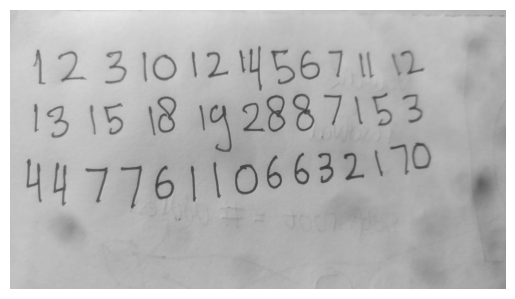

In [24]:
showPicture(img2.pixels, True)

In [25]:
shr2 = ShadowRemoval(img2)
shr2.remove()

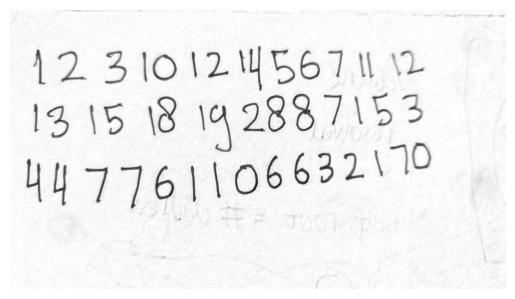

In [26]:
showPicture(shr2.output, True)

Hasil shadow removal

In [27]:
shr2.update()
#img2.accentPicture()

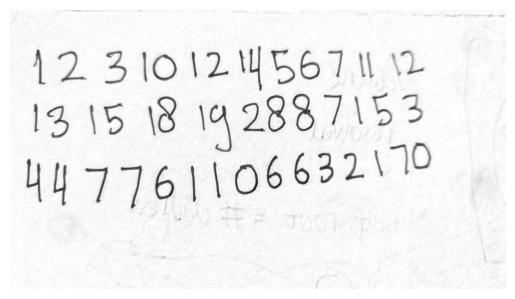

In [28]:
showPicture(img2.pixels, True)

# Image pixels density graph

In [29]:
import seaborn as sns
def plotDensity(img):
  x = img2.pixels.reshape(1, -1)[0]
  sns.set_style('whitegrid')
  plt.xlim(0, 255)
  X, Y = sns.kdeplot(x, bw=0.5, gridsize=500).get_lines()[0].get_data()

In [30]:
#plotDensity(img2.pixels)

# Input

In [69]:
ny, nx = np.shape(img2.pixels)
start_time = time()
pixels = serializeArray(img2.pixels, nx, ny)
end_time = time()
print((end_time - start_time) * 1000, 'ms')

480.84068298339844 ms


In [70]:
ny, nx = np.shape(img2.pixels)
start_time = time()
pixels = serializeArray_c(img2.pixels, nx, ny)
end_time = time()
print((end_time - start_time) * 1000, 'ms')

9.59634780883789 ms


In [71]:
start_time = time()
pixels_parallel = toMatrix(pixels, nx, ny)
end_time = time()
print((end_time - start_time) * 1000, 'ms')

15.251636505126953 ms


In [72]:
img2.pixels

array([[249, 249, 249, ..., 247, 247, 247],
       [249, 247, 249, ..., 247, 247, 247],
       [249, 249, 249, ..., 247, 247, 247],
       ...,
       [251, 251, 251, ..., 249, 249, 249],
       [251, 251, 251, ..., 253, 251, 251],
       [251, 251, 251, ..., 255, 255, 255]], dtype=uint8)

In [73]:
pixels

array([249, 249, 249, ..., 255, 255, 255], dtype=uint8)

# Image Thresholding

In [74]:
X = fromPixelsToHistogram(pixels)

In [75]:
peak = findPeak(X)

In [76]:
peak

[70, 0.00062]

In [77]:
thresh = fromPeakToThreshold(X, peak)

71 0.00055
72 0.00062
73 0.00055
74 0.00061
75 0.00053
76 0.0006
77 0.00051
78 0.00058
79 0.00049
80 0.00055
81 0.00047
82 0.00053
83 0.00045
84 0.00051
85 0.00044
86 0.0005
87 0.00042
88 0.00048
89 0.00041
90 0.00046
91 0.00039
92 0.00045
93 0.00038
94 0.00043
95 0.00036
96 0.00041
97 0.00035
98 0.0004
99 0.00033
100 0.00038
101 0.00032
102 0.00036
103 0.00031
104 0.00035
105 0.0003
106 0.00034
107 0.00028
108 0.00032
109 0.00027
110 0.00031
111 0.00027
112 0.00031
113 0.00026
114 0.0003
115 0.00025
116 0.00029
117 0.00025
118 0.00026
119 0.00026
120 0.00026
121 0.00026
122 0.00027
123 0.00027
124 0.00028
125 0.00028
126 0.00028
127 0.00028
128 0.00028
129 0.00027
130 0.00027
131 0.00027
132 0.00026
133 0.00026
134 0.00025
135 0.00024
136 0.00023
137 0.00022
138 0.00021
139 0.00024
140 0.0002
141 0.00024
142 0.0002
143 0.00023
144 0.0002
145 0.00023
146 0.0002
147 0.00023
148 0.0002
149 0.00023
150 0.0002
151 0.00023
152 0.0002
153 0.00023
154 0.0002
155 0.00023
156 0.0002
157 0.00023

In [78]:
thresh

200

In [79]:
thresh

200

In [80]:
# run this to backup image
img2.doBackup()

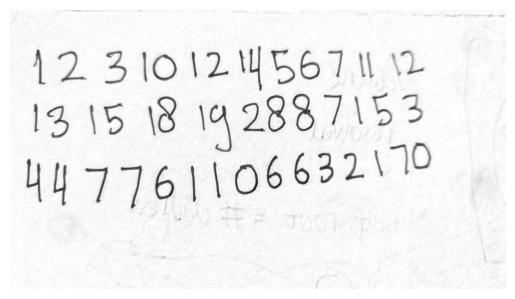

In [81]:
showPicture(img2.backup, True)

# Invert Image and Save Result

In [82]:
start_time = time()
pixels = thresh_pipeline(pixels, nx, ny, 200)
end_time = time()
print((end_time - start_time) * 1000, "ms")

[249 249 249 ... 255 255 255]
[255 255 255 ... 255 255 255]
5.921363830566406 ms


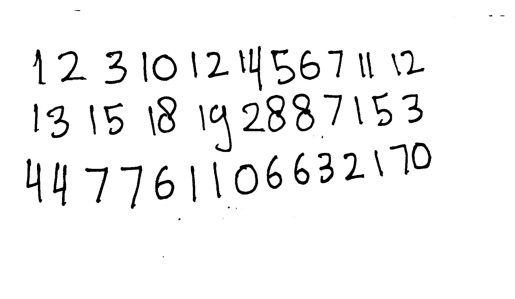

In [83]:
showPicture(pixels, False, True, nx=nx, ny=ny)

In [84]:
# save result in root/out
path = abspath("../../out/{}/frame_out.png").format(FILENAME)
img_new = PIL.Image.fromarray(fromSerialToMat(pixels, nx, ny), mode="L")
img_new.save(path, mode="L")

In [85]:
# run this to restart images to last state
# img2.restart()

# Bounding Box
Bounding box is the the smallest rectangles that encapsulate an object (for our case is a number)
To find bounding box, first find all connected pixels, then from connected pixels store the minP and maxP. Then from there, we can construct the bounding box

Algorithm Complexity is:
Time : $O(NM * log(N_{object}))$
Space : $O(min(N, M) + N_{object})$

In [86]:
start_time = time()
s, n = bbox_pipeline(pixels, nx, ny)
end_time = time()
print((end_time - start_time) * 1000, "ms")

148.89907836914062 ms


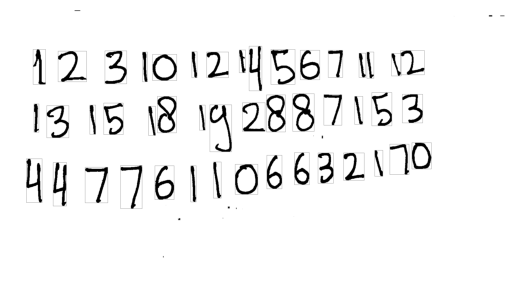

In [87]:
objs_c = []
for i in range(n):
    pos_min = s[i][0].contents
    pos_max = s[i][1].contents
    objs_c.append([[pos_min.y, pos_min.x], [pos_max.y, pos_max.x]])
    
mat_ = toMatrix(pixels, nx, ny)
res = BoundingBox.createBoundingBox(mat_, objs_c)
showPicture(res, False)

In [88]:
bbox = BoundingBox(img2.pixels)

In [89]:
start_time = time()
bbox.find()
objs_p = bbox.getObjects()
end_time = time()
print((end_time - start_time) * 1000, "ms")

11969.94686126709 ms


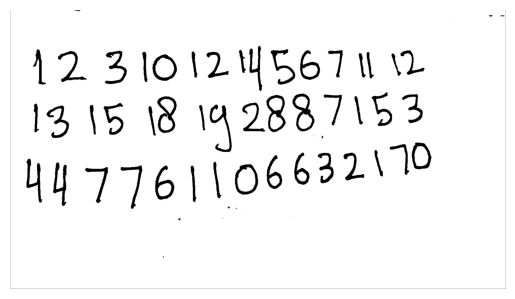

In [90]:
mat_ = toMatrix(pixels, nx, ny)
res = BoundingBox.createBoundingBox(mat_, objs_p)
showPicture(res, False)

In [91]:
# save result in root/out
path = abspath("../../out/{}/frame_out_bbox.png").format(FILENAME)
img_new = PIL.Image.fromarray(bbox.result, mode="L")
img_new.save(path, mode="L")

# Get Detected Shape
Get detected shape from bbox then scale the the image
resolution of the image must be 28 x 28 pixels

364.34078216552734 ms


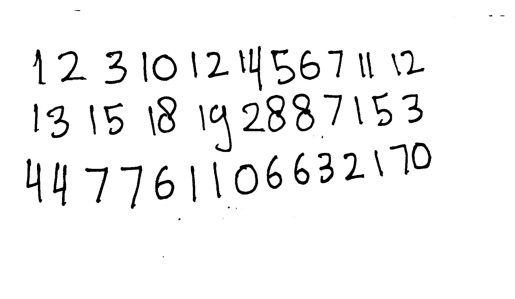

In [92]:
# for processing need images in matrix form
start_time = time()
mat = fromSerialToMat(pixels, nx, ny)
end_time = time()
print((end_time - start_time) * 1000, 'ms')
showPicture(mat, False)

5.807161331176758 ms


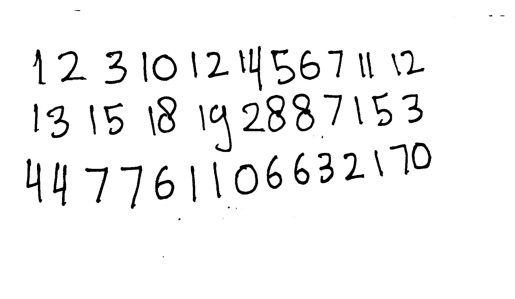

In [93]:
# for processing need images in matrix form
start_time = time()
mat = toMatrix(pixels, nx, ny)
end_time = time()
print((end_time - start_time) * 1000, 'ms')
showPicture(mat, False)

In [94]:
objs = Data(s, n)
partitions = sortObjs_c(objs)

(960, 1706)


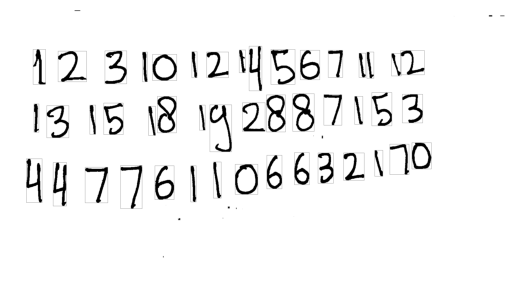

In [95]:
objs_c = []
for i in range(n):
    pos_min = objs.object[i][0].contents
    pos_max = objs.object[i][1].contents
    objs_c.append([[pos_min.y, pos_min.x], [pos_max.y, pos_max.x]])
mat_ = toMatrix(pixels, nx, ny)
print(np.shape(mat_))
res = BoundingBox.createBoundingBox(mat_, objs_c)
showPicture(res, False)

In [97]:
start = 0
ny, nx = np.shape(img2.pixels)
img_data = Image(img=np.ctypeslib.as_ctypes(pixels), nx=nx, ny=ny)
original_shapes = [None for i in range(n)]
for end in partitions:
    end = int(end)
    for i in range(start, end + 1):
        o_ = (get_shapes(img_data, objs, start, end, i))
        mat = toMatrix(o_[0], o_[1][0], o_[1][1])
        original_shapes[i] = mat
    start = end + 1

In [98]:
np.shape(original_shapes)

(61,)

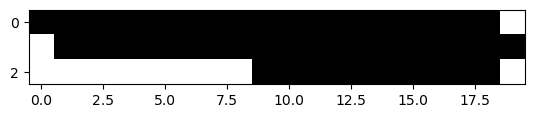

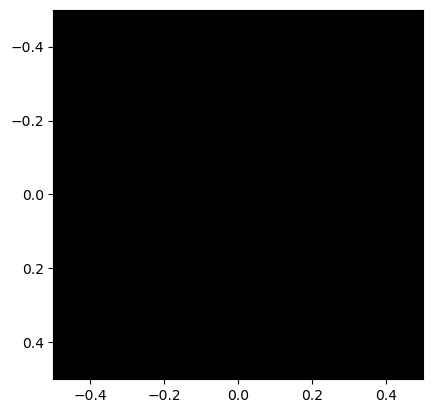

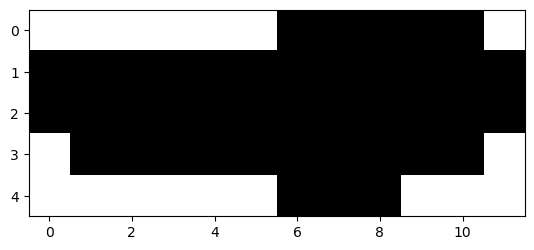

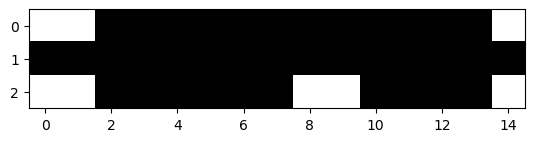

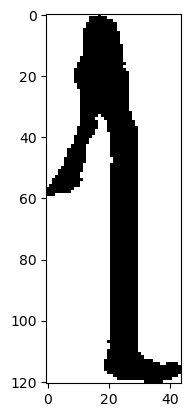

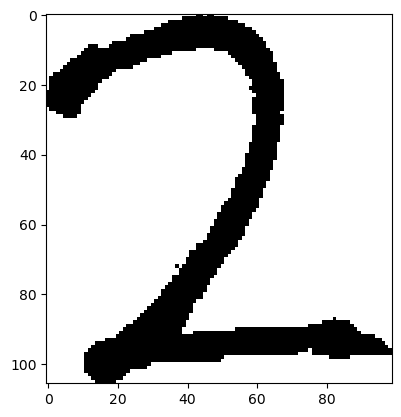

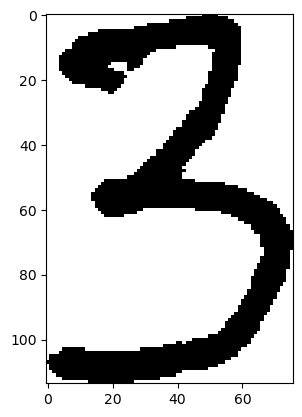

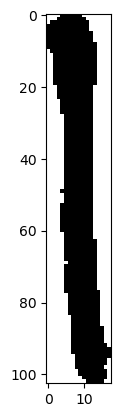

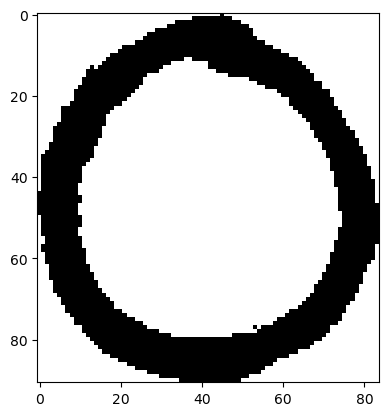

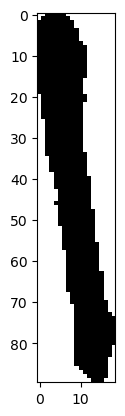

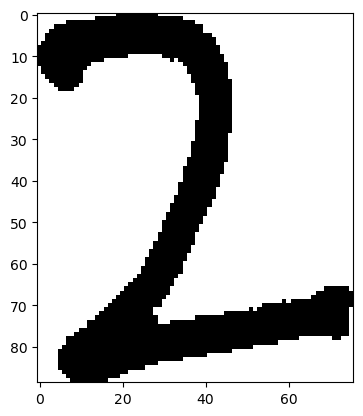

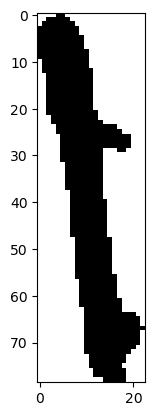

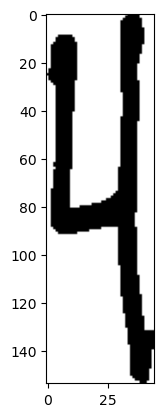

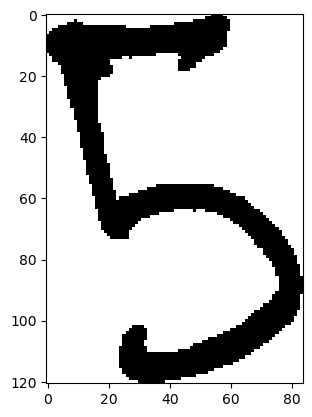

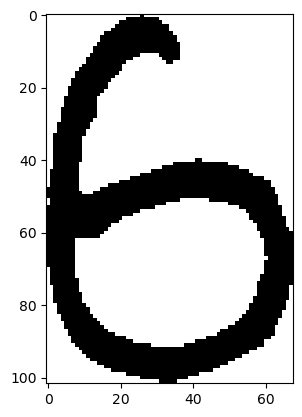

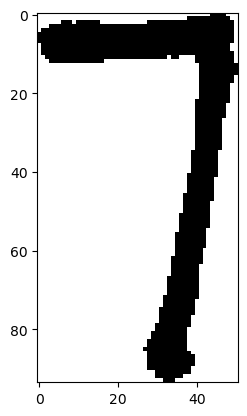

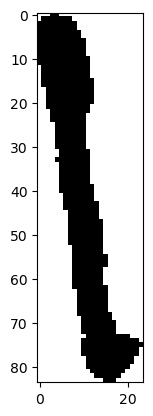

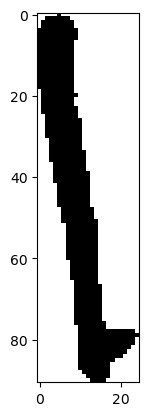

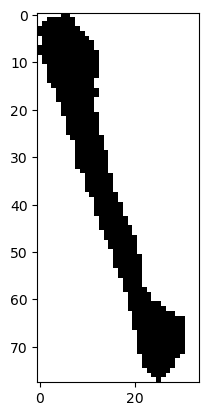

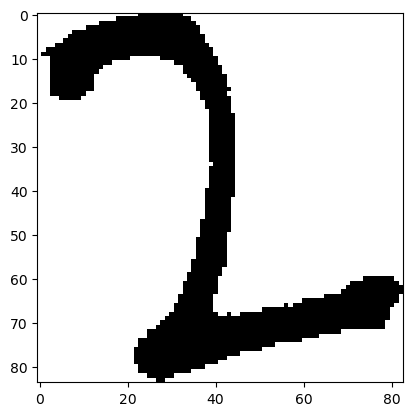

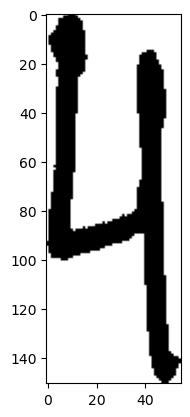

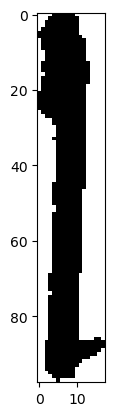

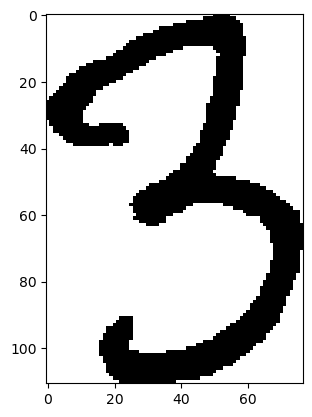

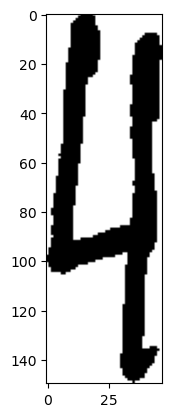

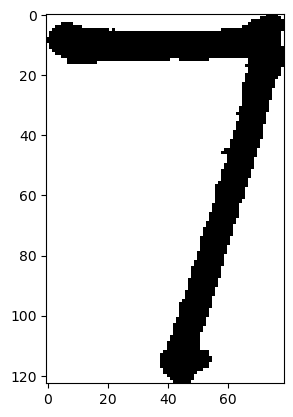

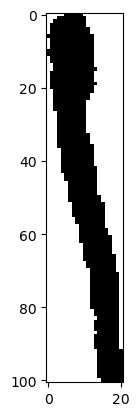

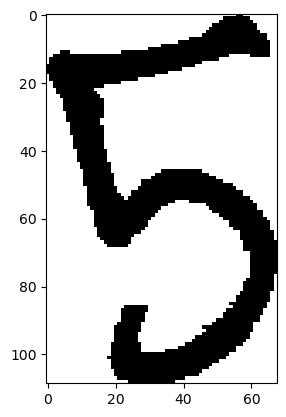

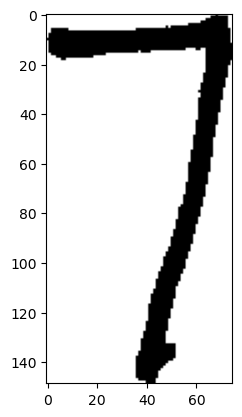

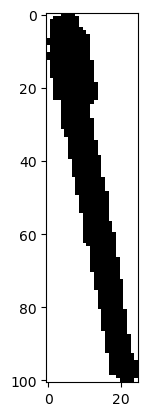

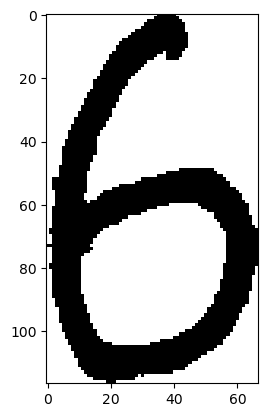

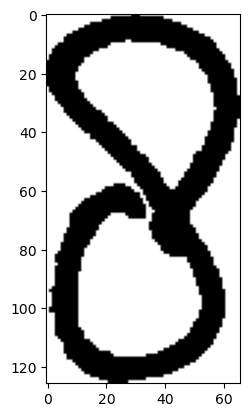

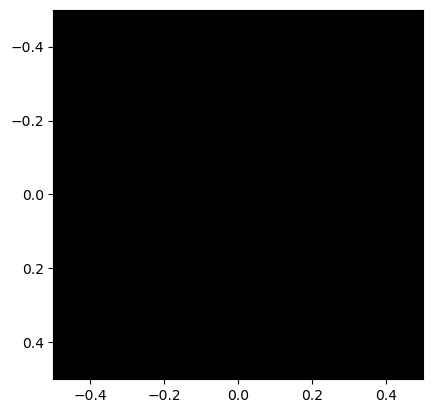

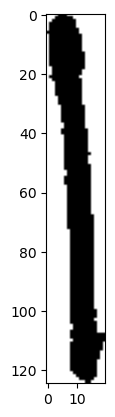

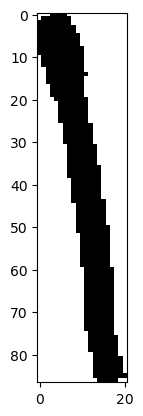

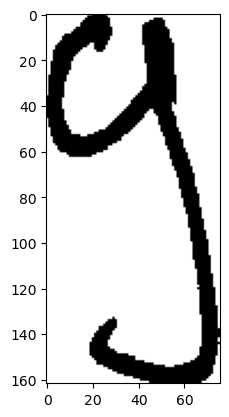

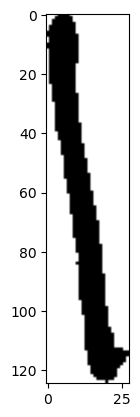

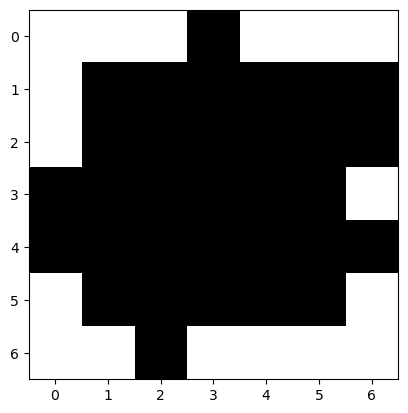

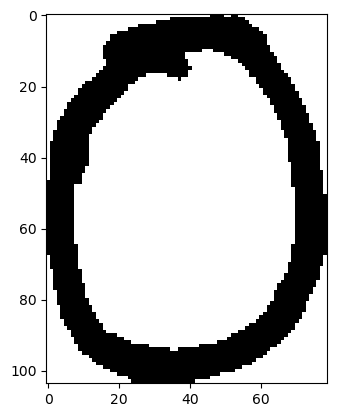

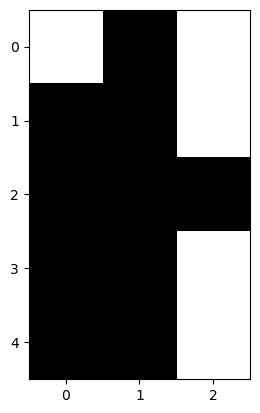

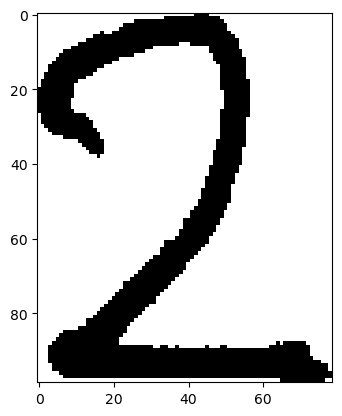

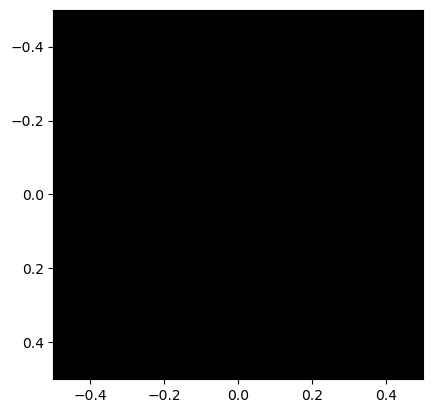

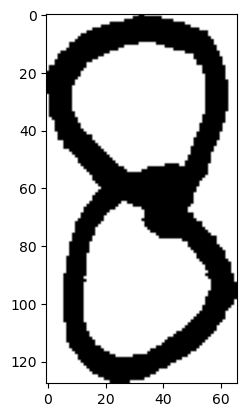

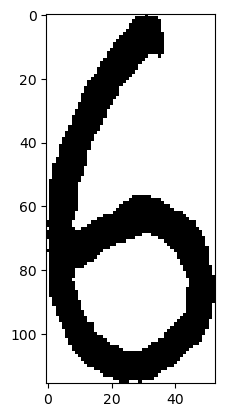

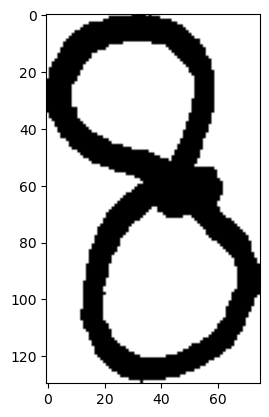

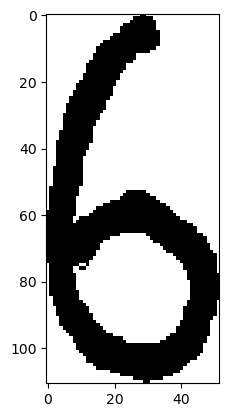

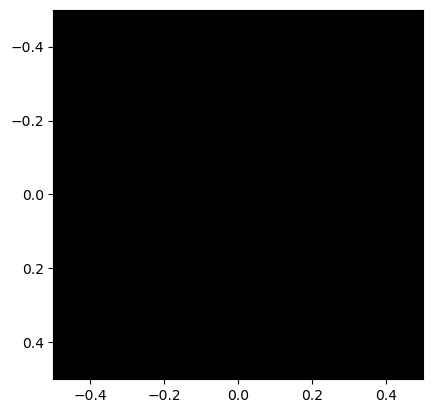

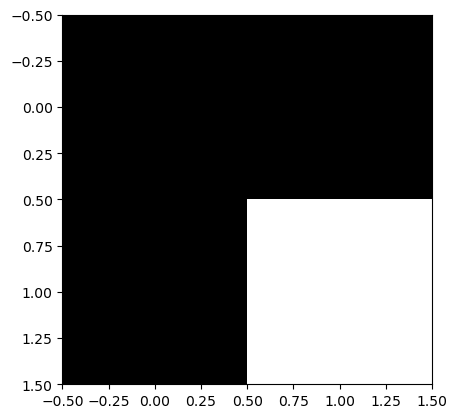

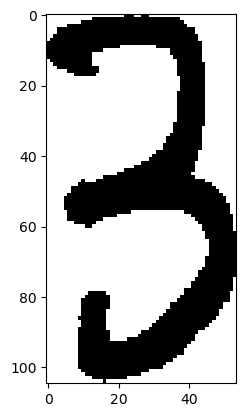

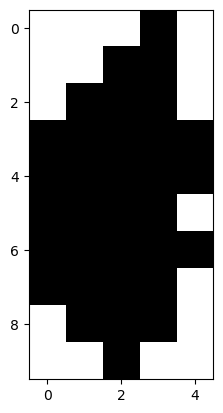

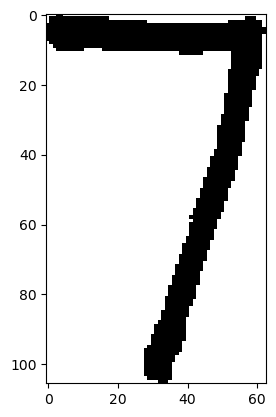

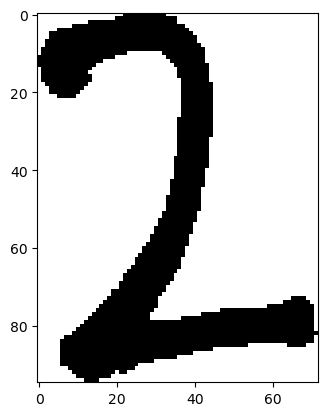

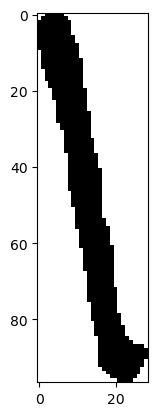

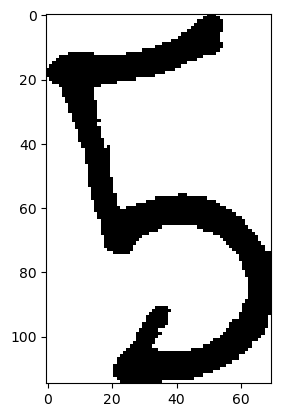

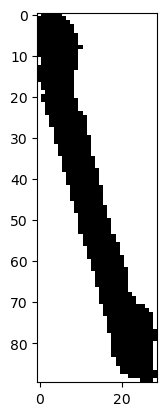

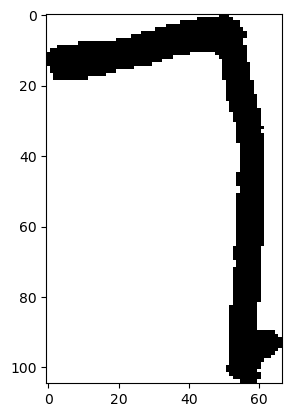

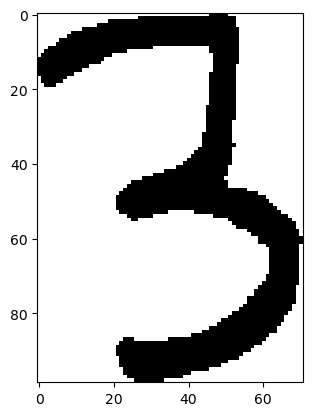

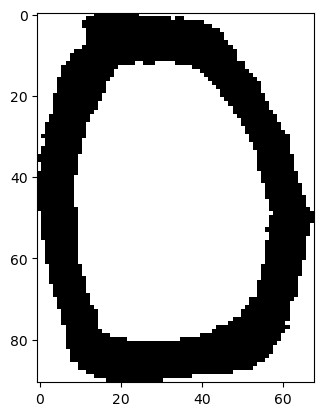

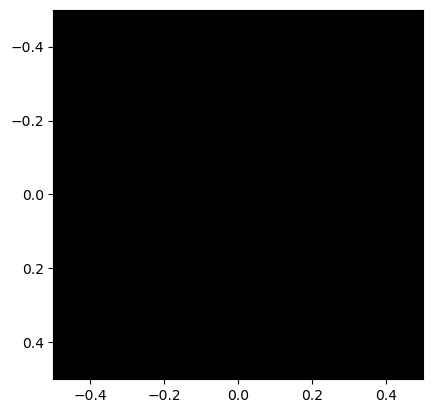

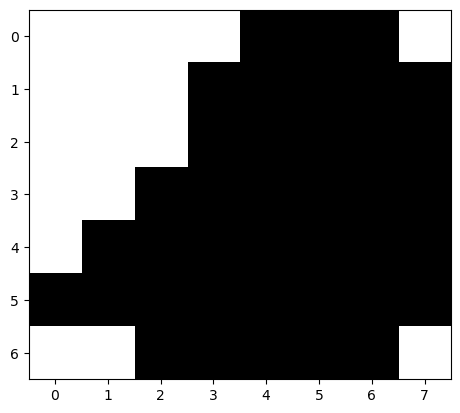

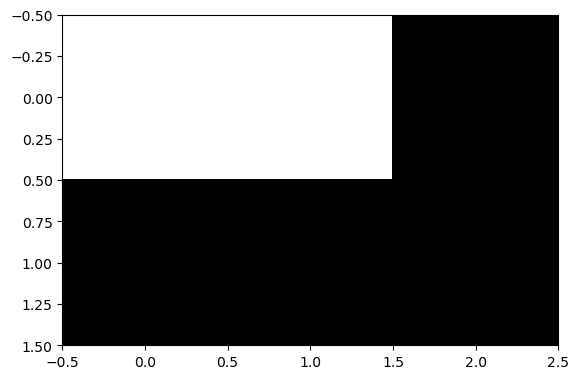

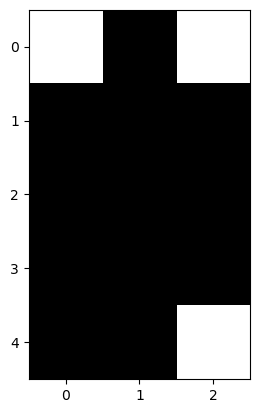

In [100]:
for shape_ in original_shapes:
    plt.imshow(shape_, cmap='gray')
    plt.show() 


In [ ]:
cnt = 0
for i in range(len(s)):
    partition = s[i]
    for j in range(len(partition)):
        shape = getShape(mat, partition, j, show=False)
        shape_erode = cv2.erode(shape, np.ones((3, 3), np.uint8))
        
        outline_s = Outline(shape_erode)
        vertexs = outline_s.findOutline()
        res = outline_s.makeOutline(vertexs)
        
        shape_erode_serialize = serializeArray(shape_erode, 28, 28)
        loops = loop_count_c(shape_erode_serialize, 28, 28)
        showPicture(res, False, caption="image {} has {} loops".format(cnt, loops))
        
        path = abspath("../../out/{}/detected_shapes/shape{}.png").format(FILENAME, cnt)
        path_outlines = abspath("../../out/{}/detected_shapes/shape_outline{}.png".format(FILENAME, cnt))
        img_new = PIL.Image.fromarray(shape_erode, mode="L")
        img_outline = PIL.Image.fromarray(res, mode="L")
        img_new.save(path, mode="L")
        img_outline.save(path_outlines,mode="L")
        cnt += 1

In [131]:
def img_features(img):
    show=False
    ny, nx = np.shape(img)
    # make images has 1 : 1 ratio then center images
    centerImage(img, nx, ny)
    # scale images to 28 x 28
    img_scale = scaleImage(img, show=show)
    # erode images
    image_erode = cv2.erode(img_scale, np.ones((3, 3), np.uint8))
    image_erode_serialize = serializeArray_c(image_erode, 28, 28)
    # add lopp count features
    cnt = loop_count_c(image_erode_serialize, 28, 28)
    showPicture(image_erode, False, caption="image has {} loops".format(cnt))
    # return features
    return np.append(image_erode_serialize, cnt)

# Output

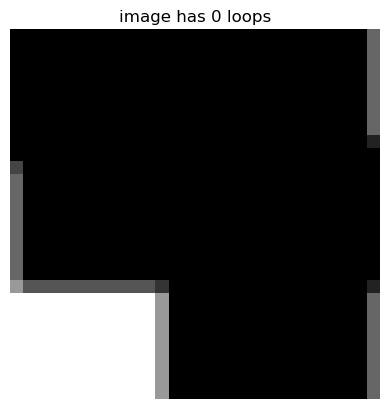

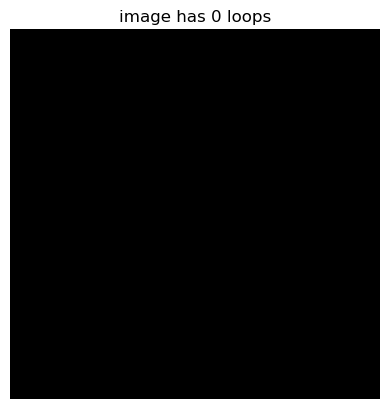

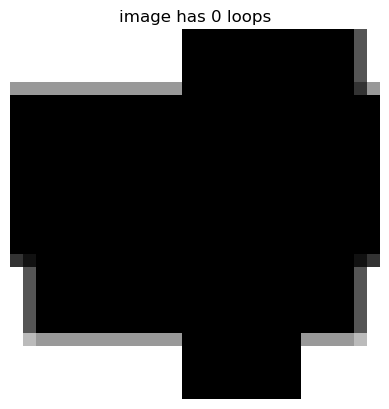

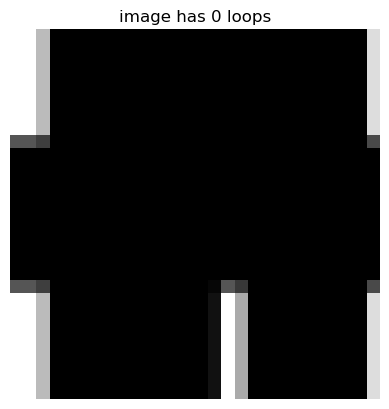

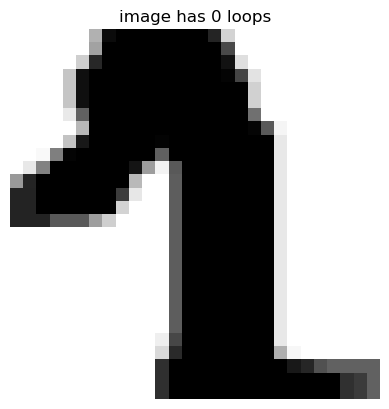

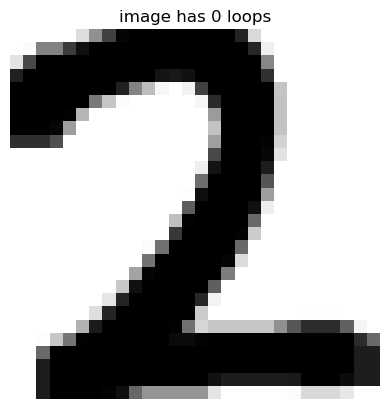

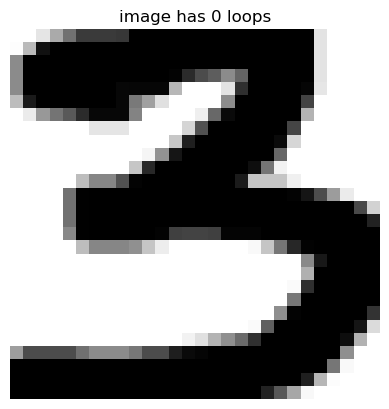

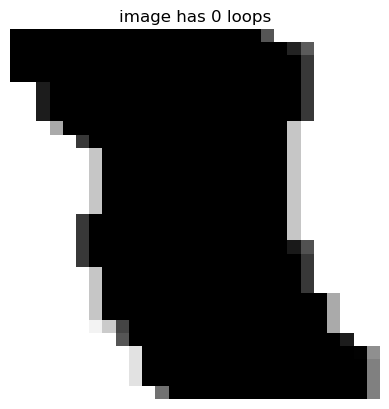

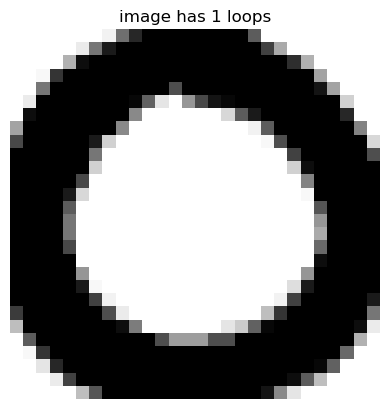

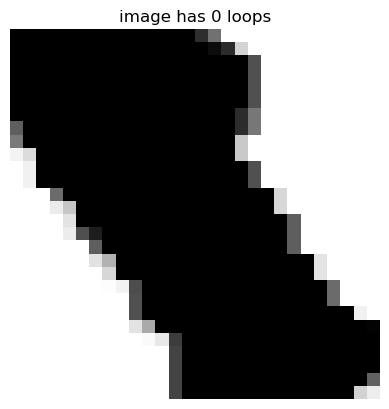

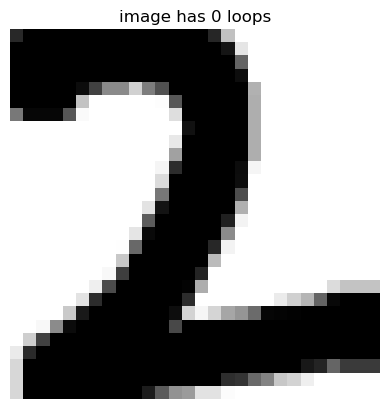

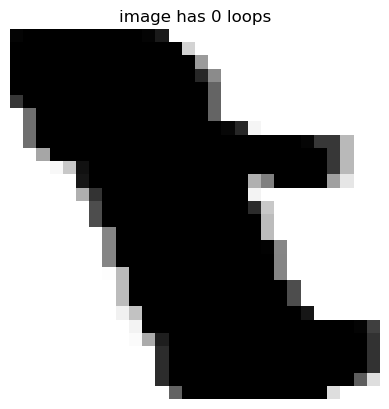

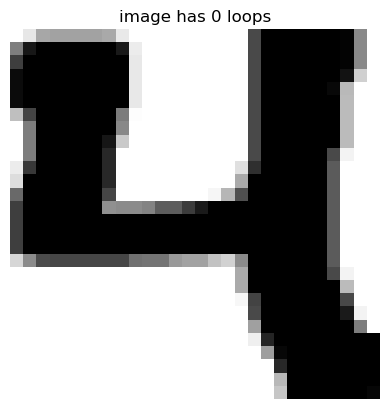

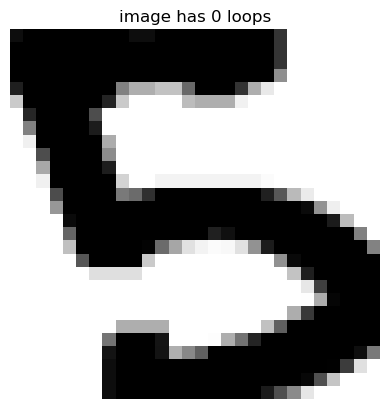

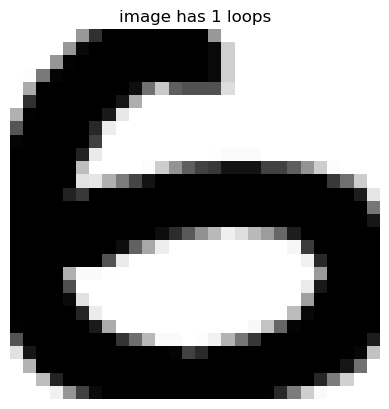

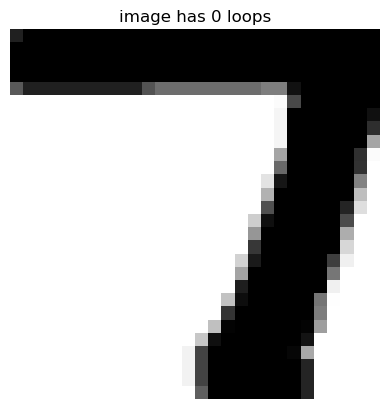

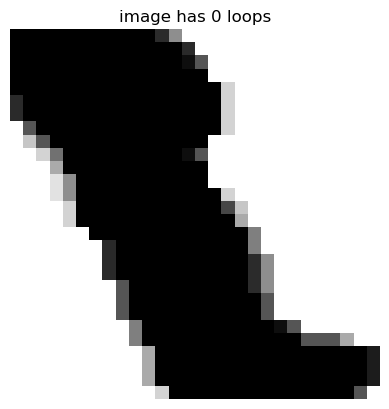

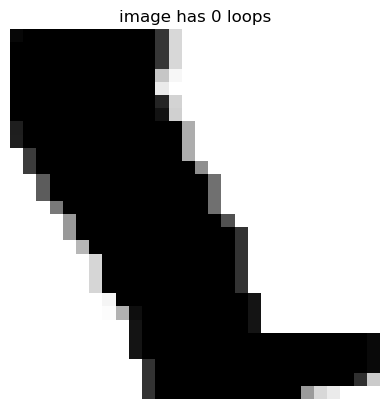

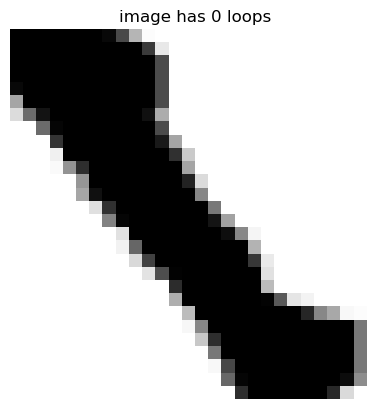

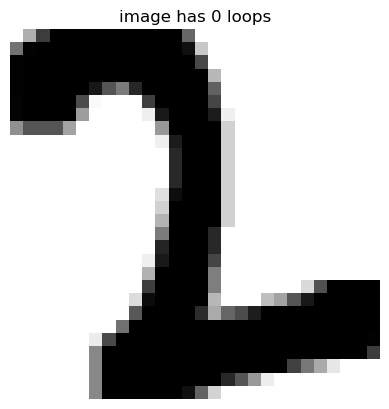

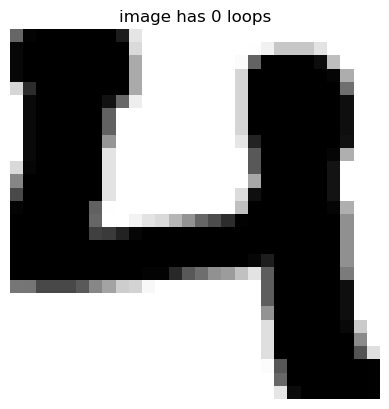

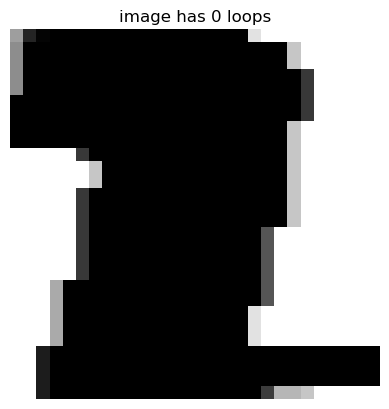

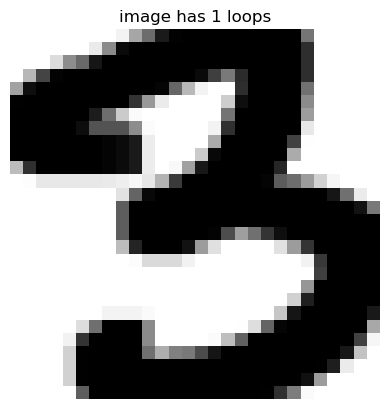

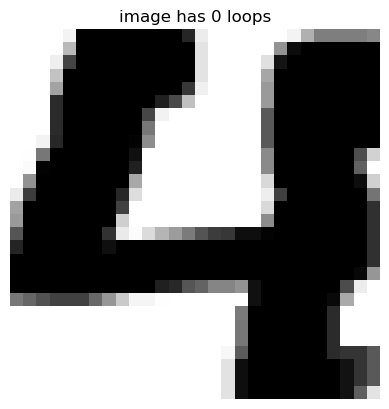

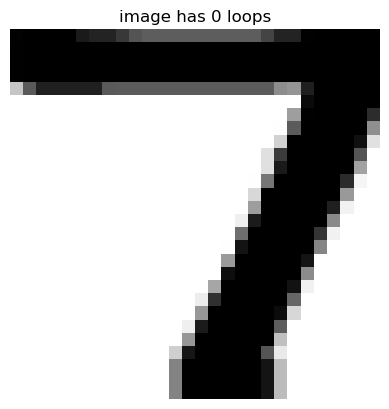

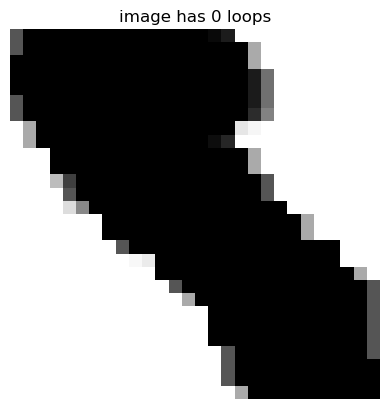

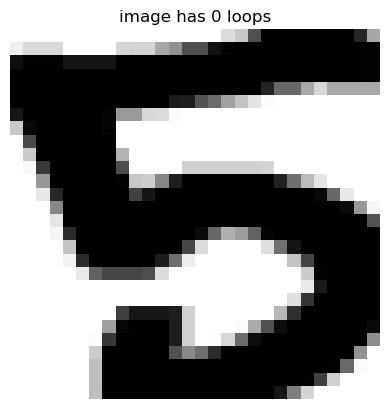

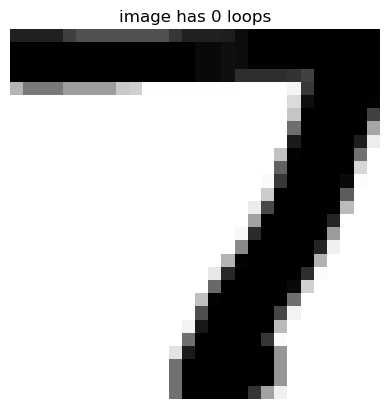

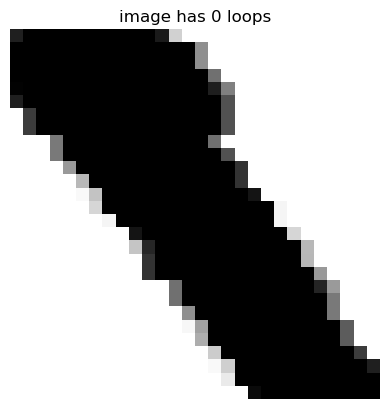

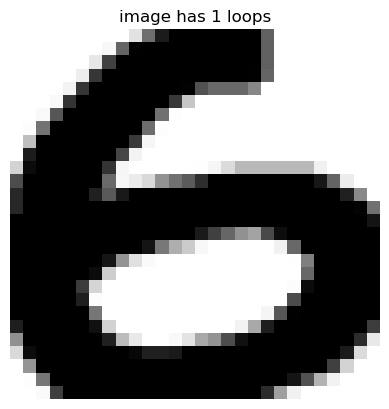

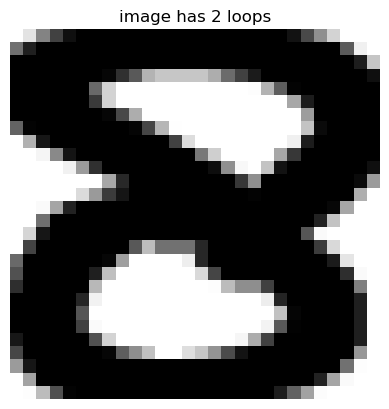

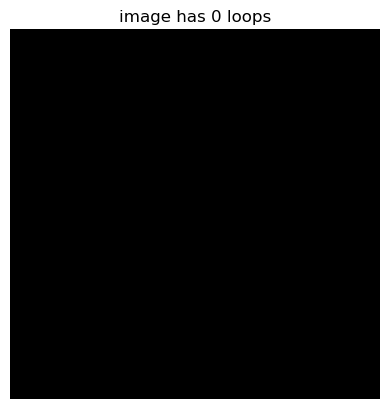

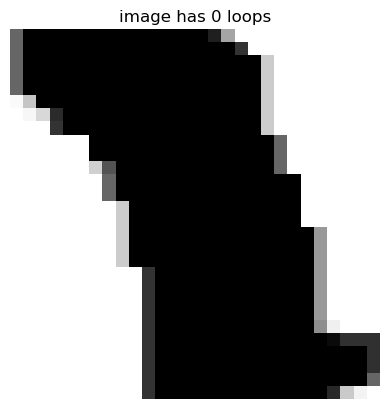

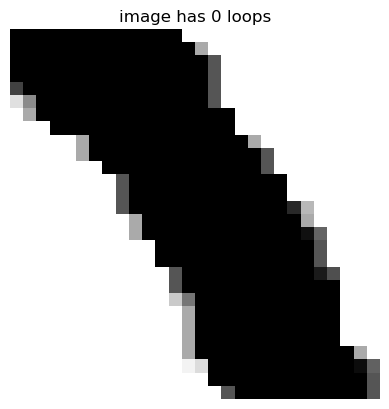

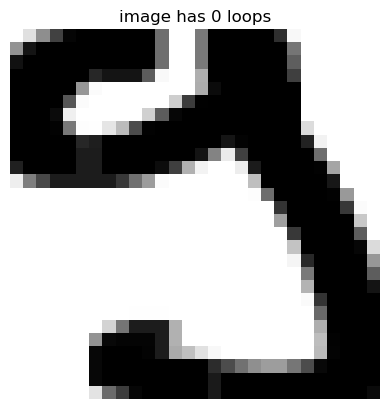

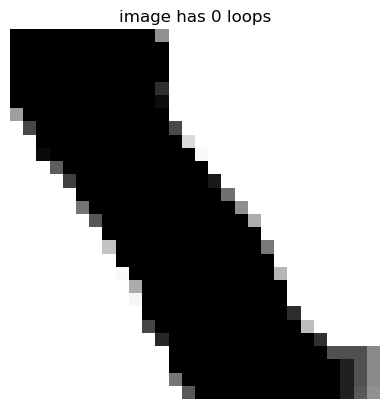

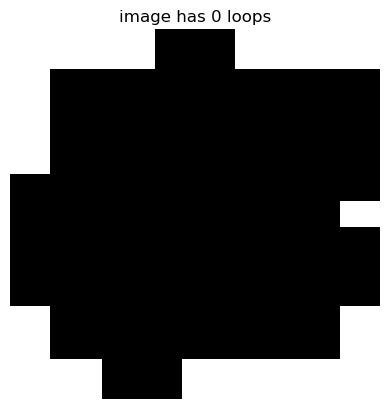

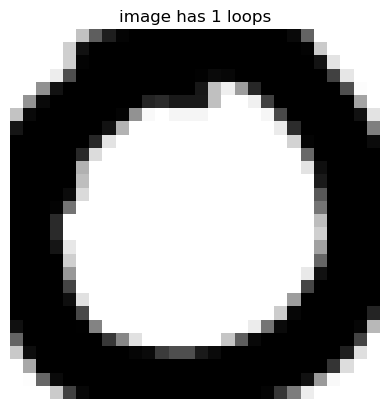

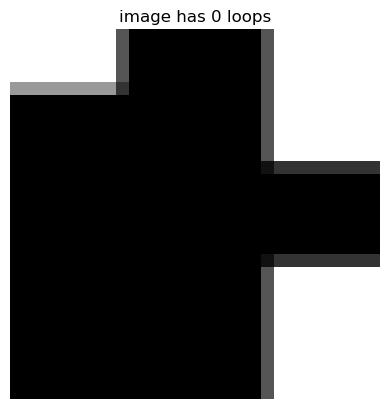

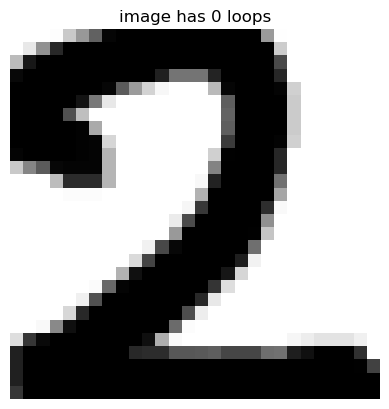

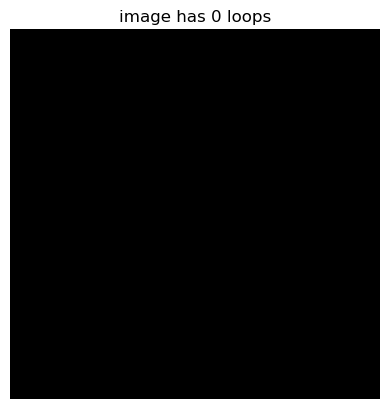

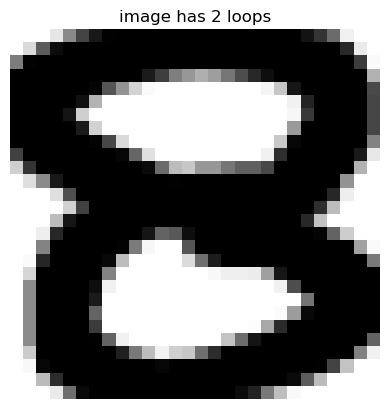

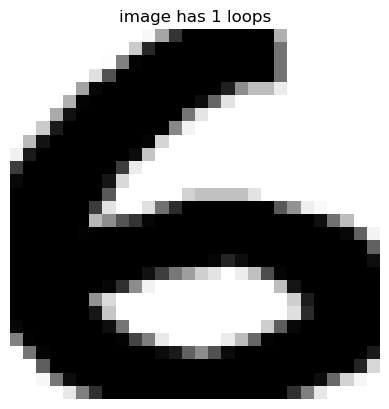

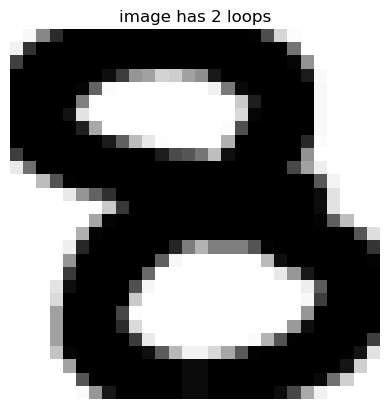

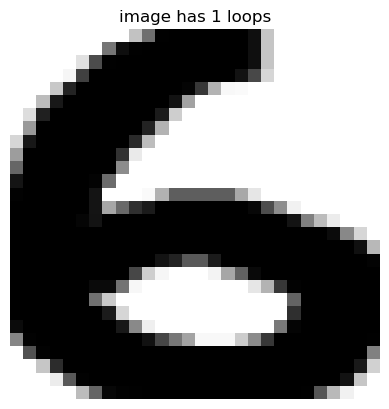

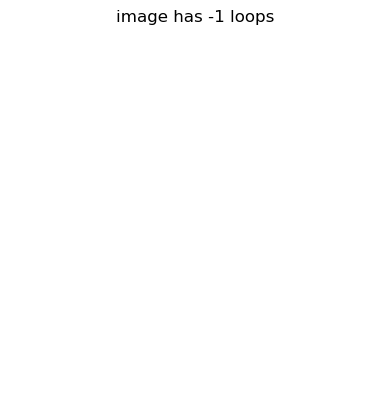

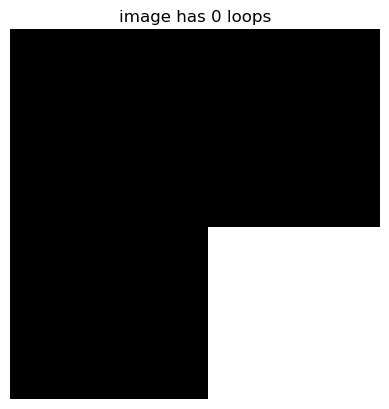

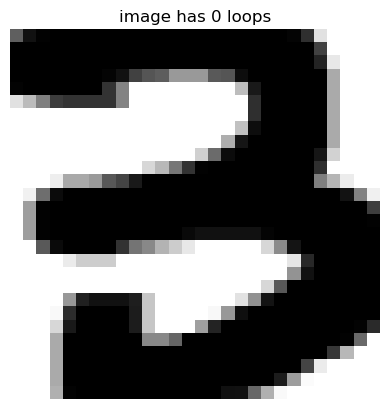

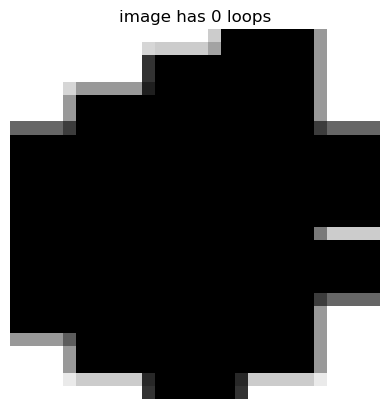

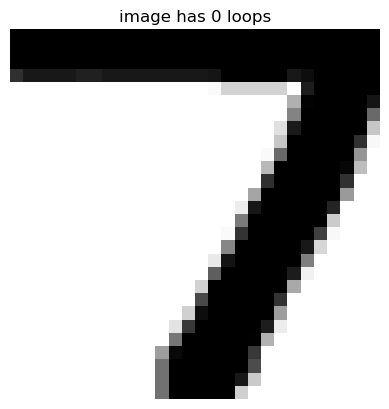

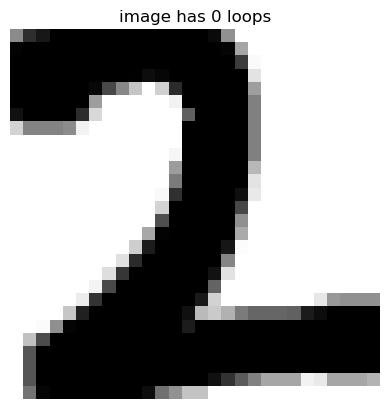

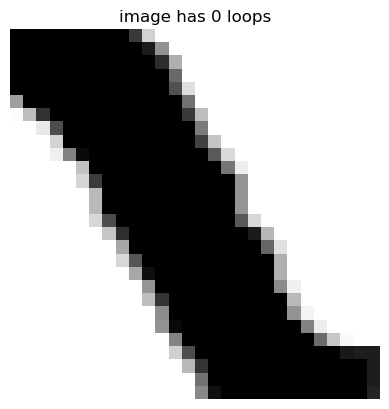

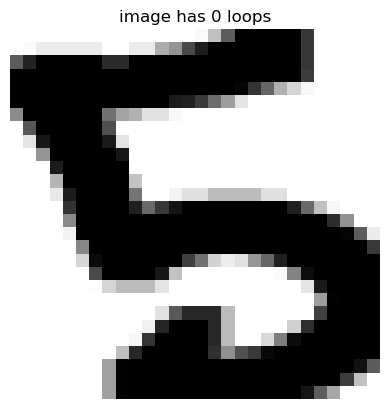

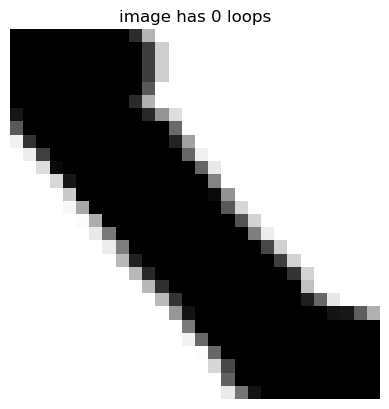

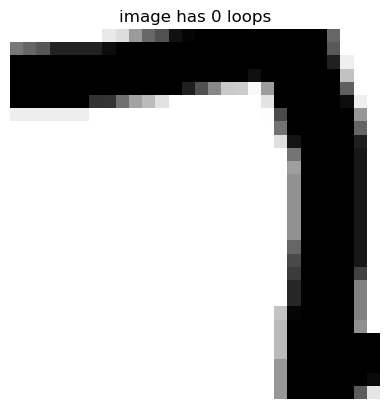

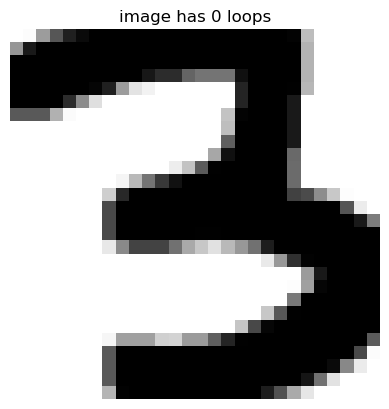

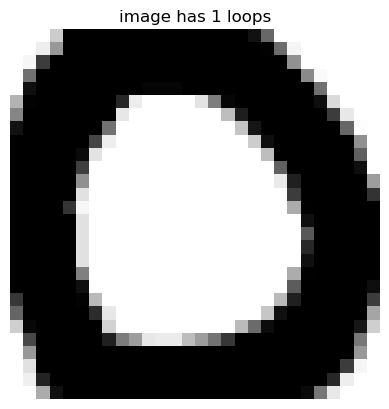

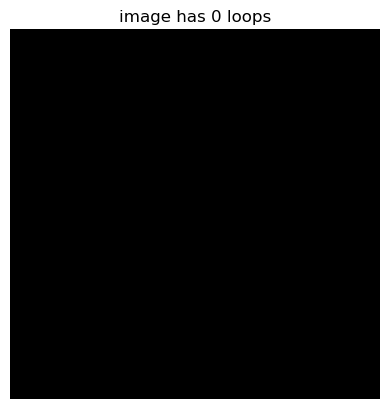

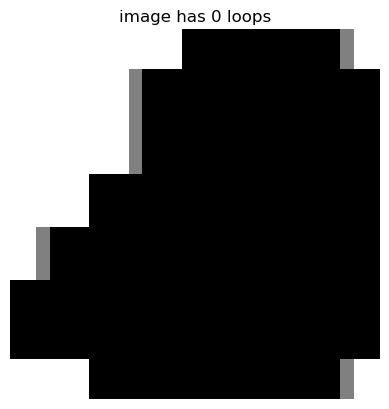

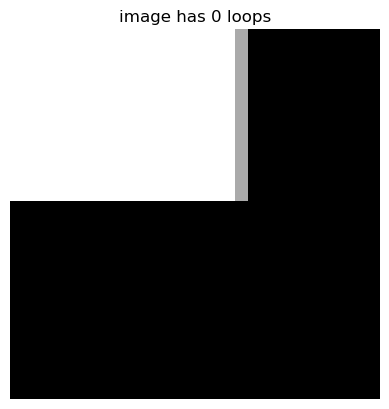

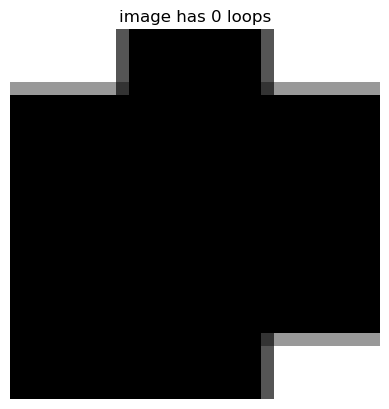

3231.576442718506
(61, 785)


In [132]:
# Serial
start_time = time()
numbers = list(map(img_features, original_shapes))
end_time = time()
print((end_time - start_time) * 1000)
print(np.shape(numbers))

# Running in parallel 
Gain up to 60% improvement in speed
Next Improvement can be achieved by getting shape using C libs

In [ ]:
from multiprocessing import Pool, cpu_count
numbers = []
def pipeline(data):
    shape = getShape(mat, partition, j)
    shape_erode = cv2.erode(shape, np.ones((3, 3), np.uint8))
    shape_erode = serializeArray_c(shape_erode, 28, 28)
    # add lopp count features
    cnt = loop_count_c(shape_erode, 28, 28)
    return np.append(shape_erode, cnt)

data = []
for i in range(len(s)):
    partition = s[i]
    for j in range(len(partition)):
        data.append([img2.pixels, partition, j])
        
start_time = time()
chunksize = len(data) // cpu_count()
with Pool(cpu_count()) as pool:
    numbers = pool.map(pipeline, data, chunksize=chunksize)
end_time = time()
print((end_time - start_time) * 1000, 'ms')        
numbers = np.array(numbers)
print(np.shape(numbers))

Numbers adalah list dari gambar objek(Angka) yang dideteksi oleh sistem. Gambar direpresentasikan dengan array of pixels. 

# References
[1]. https://stackoverflow.com/questions/4150171/how-to-create-a-density-plot-in-matplotlib </br>
[2]. https://www.geeksforgeeks.org/erosion-dilation-images-using-opencv-python/ </br>
[3]. https://medium.com/arnekt-ai/shadow-removal-with-open-cv-71e030eadaf5 </br>
[4]. https://docs.python.org/3/library/ctypes.html 